In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import numpy as np

In [3]:
# load a simple face detector
!pip install retina-face
from retinaface import RetinaFace

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load Gaze-LLE model
model, transform = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitl14_inout')
model.eval()
model.to(device)

Downloading: "https://github.com/fkryan/gazelle/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth


100%|██████████| 1.13G/1.13G [00:09<00:00, 122MB/s] 


Downloading: "https://github.com/fkryan/gazelle/releases/download/v1.0.0/gazelle_dinov2_vitl14_inout.pt" to /root/.cache/torch/hub/checkpoints/gazelle_dinov2_vitl14_inout.pt


100%|██████████| 12.2M/12.2M [00:00<00:00, 27.5MB/s]


GazeLLE(
  (backbone): DinoV2Backbone(
    (model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (drop): Dropout(p=0.0, inpla

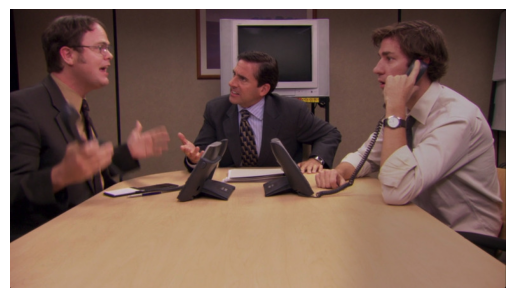

In [5]:
# load an input image

image_url = "https://www.looper.com/img/gallery/the-office-funniest-moments-ranked/jim-and-dwights-customer-service-training-1627594561.jpg"
# image_url = "https://ew.com/thmb/n5b8Asz4Y5Lp0sSEF7WgS-ESyFc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/succession-finale-052923-ec304aabcbf24a7b9fad891a87f49b74.jpg"
# image_url = "https://i.kym-cdn.com/entries/icons/original/000/045/575/blackcatzoningout_meme.jpg"

try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    image = Image.open(BytesIO(response.content))
    width, height = image.size

    plt.imshow(image)
    plt.axis('off')
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [6]:
# detect faces
resp = RetinaFace.detect_faces(np.array(image))
print(resp)
bboxes = [resp[key]['facial_area'] for key in resp.keys()]
print(bboxes)

25-11-15 10:25:53 - Directory /root/.deepface created
25-11-15 10:25:53 - Directory /root/.deepface/weights created
25-11-15 10:25:53 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 98.7MB/s]


{'face_1': {'score': np.float64(0.9995856881141663), 'facial_area': [np.int64(343), np.int64(80), np.int64(393), np.int64(148)], 'landmarks': {'right_eye': [np.float32(351.53635), np.float32(104.458755)], 'left_eye': [np.float32(364.2473), np.float32(109.84246)], 'nose': [np.float32(345.343), np.float32(118.26524)], 'mouth_right': [np.float32(349.05673), np.float32(129.60373)], 'mouth_left': [np.float32(358.86234), np.float32(133.21274)]}}, 'face_2': {'score': np.float64(0.9990641474723816), 'facial_area': [np.int64(102), np.int64(28), np.int64(161), np.int64(119)], 'landmarks': {'right_eye': [np.float32(141.36621), np.float32(60.725178)], 'left_eye': [np.float32(151.70895), np.float32(62.10516)], 'nose': [np.float32(160.81204), np.float32(76.4635)], 'mouth_right': [np.float32(140.18956), np.float32(93.66838)], 'mouth_left': [np.float32(149.57648), np.float32(95.37327)]}}, 'face_3': {'score': np.float64(0.9970556497573853), 'facial_area': [np.int64(574), np.int64(44), np.int64(633), np

In [7]:
# prepare gazelle input
img_tensor = transform(image).unsqueeze(0).to(device)
norm_bboxes = [[np.array(bbox) / np.array([width, height, width, height]) for bbox in bboxes]]

input = {
    "images": img_tensor, # [num_images, 3, 448, 448]
    "bboxes": norm_bboxes # [[img1_bbox1, img1_bbox2...], [img2_bbox1, img2_bbox2]...]
}

with torch.no_grad():
    output = model(input)

img1_person1_heatmap = output['heatmap'][0][0] # [64, 64] heatmap
print(img1_person1_heatmap.shape)
if model.inout:
  img1_person1_inout = output['inout'][0][0] # gaze in frame score (if model supports inout prediction)
  print(img1_person1_inout.item())


torch.Size([64, 64])
0.9942521452903748


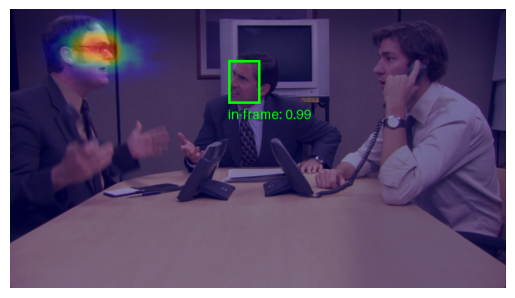

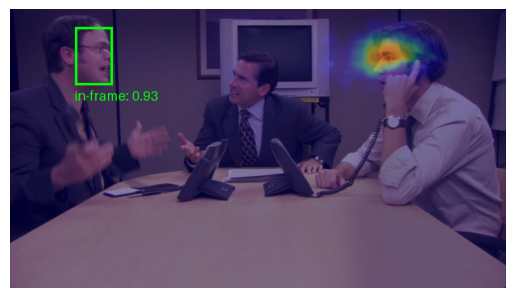

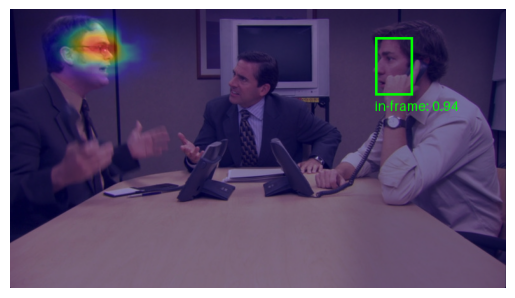

In [8]:
# visualize predicted gaze heatmap for each person and gaze in/out of frame score

def visualize_heatmap(pil_image, heatmap, bbox=None, inout_score=None):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(pil_image.size, Image.Resampling.BILINEAR)
    heatmap = plt.cm.jet(np.array(heatmap) / 255.)
    heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
    heatmap = Image.fromarray(heatmap).convert("RGBA")
    heatmap.putalpha(90)
    overlay_image = Image.alpha_composite(pil_image.convert("RGBA"), heatmap)

    if bbox is not None:
        width, height = pil_image.size
        xmin, ymin, xmax, ymax = bbox
        draw = ImageDraw.Draw(overlay_image)
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline="lime", width=int(min(width, height) * 0.01))

        if inout_score is not None:
          text = f"in-frame: {inout_score:.2f}"
          text_width = draw.textlength(text)
          text_height = int(height * 0.01)
          text_x = xmin * width
          text_y = ymax * height + text_height
          draw.text((text_x, text_y), text, fill="lime", font=ImageFont.load_default(size=int(min(width, height) * 0.05)))
    return overlay_image

for i in range(len(bboxes)):
  plt.figure()
  plt.imshow(visualize_heatmap(image, output['heatmap'][0][i], norm_bboxes[0][i], inout_score=output['inout'][0][i] if output['inout'] is not None else None))
  plt.axis('off')
  plt.show()



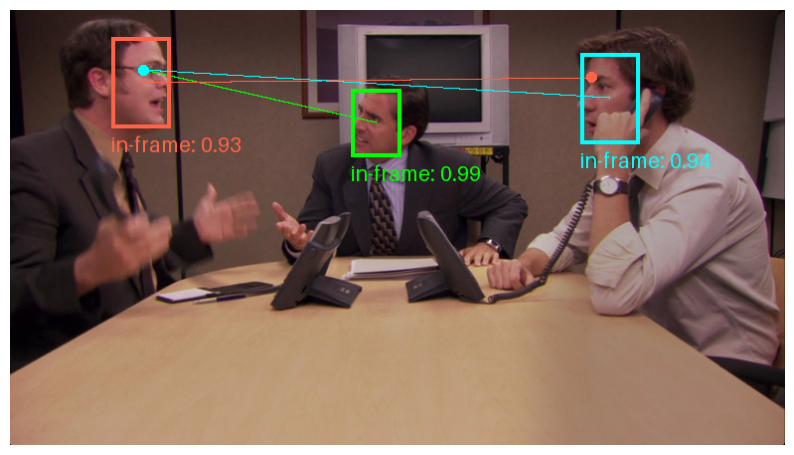

In [9]:
# combined visualization with maximal gaze points for each person

def visualize_all(pil_image, heatmaps, bboxes, inout_scores, inout_thresh=0.5):
    colors = ['lime', 'tomato', 'cyan', 'fuchsia', 'yellow']
    overlay_image = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(overlay_image)
    width, height = pil_image.size

    for i in range(len(bboxes)):
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        color = colors[i % len(colors)]
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline=color, width=int(min(width, height) * 0.01))

        if inout_scores is not None:
            inout_score = inout_scores[i]
            text = f"in-frame: {inout_score:.2f}"
            text_width = draw.textlength(text)
            text_height = int(height * 0.01)
            text_x = xmin * width
            text_y = ymax * height + text_height
            draw.text((text_x, text_y), text, fill=color, font=ImageFont.load_default(size=int(min(width, height) * 0.05)))

        if inout_scores is not None and inout_score > inout_thresh:
            heatmap = heatmaps[i]
            heatmap_np = heatmap.detach().cpu().numpy()
            max_index = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
            gaze_target_x = max_index[1] / heatmap_np.shape[1] * width
            gaze_target_y = max_index[0] / heatmap_np.shape[0] * height
            bbox_center_x = ((xmin + xmax) / 2) * width
            bbox_center_y = ((ymin + ymax) / 2) * height

            draw.ellipse([(gaze_target_x-5, gaze_target_y-5), (gaze_target_x+5, gaze_target_y+5)], fill=color, width=int(0.005*min(width, height)))
            draw.line([(bbox_center_x, bbox_center_y), (gaze_target_x, gaze_target_y)], fill=color, width=int(0.005*min(width, height)))

    return overlay_image

plt.figure(figsize=(10,10))
plt.imshow(visualize_all(image, output['heatmap'][0], norm_bboxes[0], output['inout'][0] if output['inout'] is not None else None, inout_thresh=0.5))
plt.axis('off')
plt.show()